In this example, we create a sinogram using a Shepp-Logan phantom and use self-supervised CNNs to reconstruct the tomographic image. The following CNNs can be tested: Automap, GANrec and SD2I with/without upsampling layers.

In [ ]:
from nDTomo.sim.shapes.phantoms import SheppLogan
from nDTomo.utils.misc import showim
from nDTomo.ct.conv_tomo import fbpvol, sinocentering

from nDTomo.nn.models_tf import GANrec, SD2I, Automap, Discriminator
from nDTomo.nn.utils_tf import tf_gpu_devices, ReduceLROnPlateau_custom
from nDTomo.nn.tomo_tf import tf_create_angles, tf_tomo_transf, tf_tomo_radon, tf_tomo_squeeze, tf_tomo_bp, tf_mask_circle
from nDTomo.nn.losses_tf import ssim_mae_loss, discriminator_loss
from nDTomo.utils.misc import cirmask

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

Check if Tensorflow will run on GPU

In [2]:
tf_gpu_devices()

physical_devices = tf.config.list_physical_devices('GPU') 

print(physical_devices)

for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

Default GPU Device:/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Let's create the image, sinogram, and mask.

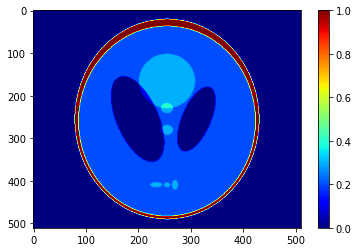

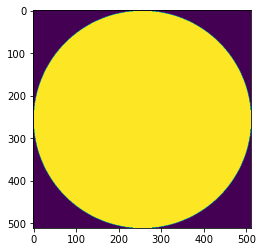

In [3]:
npix = 511 # image size
npr = 512 # number of projections
ang_samp = 4 # angular undersampling factor

npr = npr // ang_samp

with_disc = True # Use discriminator or not

method = 'GANrec' # Choose method from 'SD2Iup', 'SD2I', 'GANrec', 'Automap'

factor = 8 # Used for SD2I methods

nim = 1

im = SheppLogan(npix)
showim(im, 1, cmap = 'jet')

mask = np.ones((npix, npix))
mask = cirmask(mask,0)

mask = np.repeat(mask[:, :, np.newaxis], 1, axis=2)
plt.imshow(mask[:,:,0])

Let's create the sinogram

(1, 511, 511, 1)


c:\programdata\anaconda3\lib\site-packages\tensorflow_addons\image\transform_ops.py:142: UserWarning: fill_value is not supported and is always 0 for TensorFlow < 2.4.0.
  warnings.warn(


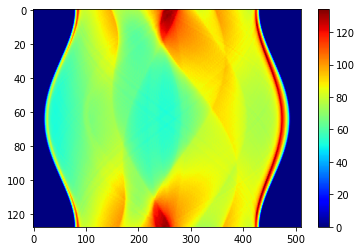

(1, 128, 511)


In [4]:
data = im.reshape([npix,npix,1])

theta = tf_create_angles(npr)

imtf = tf_tomo_transf(im)
print(imtf.shape)

pattern_input = tf_tomo_radon(imtf, theta, interp_method='bilinear')
showim(tf_tomo_squeeze(pattern_input), 2)
pattern_input = pattern_input[:,:,:,0]

print(pattern_input.shape)

Calculate the reconstructed image using the filtered back projection algorithm

In [ ]:
fbp = fbpvol(np.array(pattern_input[0]).transpose(), theta=np.rad2deg(theta), nt = npix)
showim(fbp, 3, clim=(0, np.max(fbp)))

Next we prepare the function for training the neural network

Training loop

In [33]:
if not with_disc:
    @tf.function 
    def train_step(input_number, dataset):
        print(1)
        with tf.GradientTape(persistent=True) as tape:

            generated_img = generator(input_number)
            generated_img = tf.math.abs(generated_img)

            print(generated_img.shape)

            pattern_gen = tf_tomo_radon(generated_img, theta)
            pattern_gen = pattern_gen[:,:,:,0]
            pattern_gen = tf.transpose(pattern_gen, [1, 2, 0])
            dataset = tf.transpose(dataset, [1, 2, 0])
            print(3)
            print(pattern_gen.shape)
            print(dataset.shape)

            matrix_loss = ssim_mae_loss(dataset, pattern_gen)

        grad_gen = tape.gradient(matrix_loss, generator.trainable_variables)

        gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
        return matrix_loss

else:
    @tf.function 
    def train_step(input_number, dataset):
        print(1)
        with tf.GradientTape(persistent=True) as tape:

            generated_img = generator(input_number)
            generated_img = tf.math.abs(generated_img)
            print(generated_img.shape)

            pattern_gen = tf_tomo_radon(generated_img, theta)
            
            real_output = discriminator(tf.expand_dims(dataset, -1))
            generated_output = discriminator(pattern_gen)
            
            pattern_gen = pattern_gen[:,:,:,0]
            pattern_gen = tf.transpose(pattern_gen, [1, 2, 0])
            dataset = tf.transpose(dataset, [1, 2, 0])
            print(2)
            print(dataset.shape)
            print(pattern_gen.shape)
            gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generated_output,
                                      labels=tf.ones_like(generated_output))) \
                       + ssim_mae_loss(dataset, pattern_gen)

            disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output, labels=tf.ones_like(real_output)))
            disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generated_output, labels=tf.zeros_like(generated_output)))
            disc_loss = disc_loss_real+disc_loss_fake

        grad_disc = tape.gradient(disc_loss, discriminator.trainable_variables)
        grad_gen = tape.gradient(gen_loss, generator.trainable_variables)

        disc_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))
        gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
        print(3)
        return gen_loss

Setup the model, optimizers and learning rate

In [35]:
if method == 'SD2Iup':
    generator = SD2I(npix, factor)
elif method == 'SD2I':
    generator = SD2I(npix, factor, upsample=False)
elif method == 'GANrec':
    generator = GANrec(npix, npr)
elif method == 'Automap':
    generator = Automap(npix, npr)
    
if with_disc:
    discriminator = Discriminator(npix, npr)
    disc_optimizer = tf.keras.optimizers.Adam(0.0005)
    
generator.summary()
gen_optimizer = tf.keras.optimizers.Adam(0.0005)

reduce_rl_plateau = ReduceLROnPlateau_custom(patience=int(200/100),
                            factor=0.5,
                            verbose=1, 
                            optim_lr=gen_optimizer.learning_rate, 
                            reduce_lin=True)


Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 511, 511, 1)]     0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 261121)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               66847232  
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_18 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_19 (Dense)             (None, 261121)            67108097  
_________________________________________________________________
reshape_8 (Reshape)          (None, 511, 511, 1)      

Setup the epochs needed and start the training loop.

In [37]:
epochs = 8000
save_interval = 100

chemct_tf = tf.cast(pattern_input, 'float32')

if method == 'GANrec':
    bp = tf_tomo_bp(chemct_tf, theta)
    input_number = bp
elif method == 'Automap':
    input_number = chemct_tf
else:
    input_number = tf.cast(np.array([1]), 'float32')

start = time.time()
reduce_rl_plateau.on_train_begin()
kk = 1

for epoch in tqdm(range(epochs)):

    loss = train_step(input_number, chemct_tf)

    if epoch % save_interval == 0 and epoch != 0:

        print('Time for epoch {} to {} is {} sec/it - gen_loss = {}'.format(epoch - save_interval + 1, epoch, (time.time() - start) / save_interval, loss))
        start = time.time()
        plt.close()

        reduce_rl_plateau.on_epoch_end(kk, loss)
        kk += 1



  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

1
(1, 511, 511, 1)
2
(128, 511, 1)
(128, 511, 1)
3
1
(1, 511, 511, 1)
2
(128, 511, 1)
(128, 511, 1)
3


  1%|█                                                                              | 102/8000 [00:25<19:47,  6.65it/s]

Time for epoch 1 to 100 is 0.25084874629974363 sec/it - gen_loss = 1.5632200241088867


  3%|█▉                                                                             | 202/8000 [00:40<19:43,  6.59it/s]

Time for epoch 101 to 200 is 0.1542903971672058 sec/it - gen_loss = 3.0126233100891113


  4%|██▉                                                                            | 302/8000 [00:56<19:44,  6.50it/s]

Time for epoch 201 to 300 is 0.15563700199127198 sec/it - gen_loss = 2.206195116043091

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


  5%|███▉                                                                           | 402/8000 [01:12<19:32,  6.48it/s]

Time for epoch 301 to 400 is 0.15694063186645507 sec/it - gen_loss = 1.1736574172973633


  6%|████▉                                                                          | 502/8000 [01:27<19:19,  6.47it/s]

Time for epoch 401 to 500 is 0.15806797742843628 sec/it - gen_loss = 1.2004185914993286


  8%|█████▉                                                                         | 602/8000 [01:43<19:08,  6.44it/s]

Time for epoch 501 to 600 is 0.15814735889434814 sec/it - gen_loss = 1.1690387725830078


  9%|██████▉                                                                        | 702/8000 [01:59<18:57,  6.41it/s]

Time for epoch 601 to 700 is 0.15837918043136598 sec/it - gen_loss = 1.1984835863113403


 10%|███████▉                                                                       | 802/8000 [02:15<18:40,  6.42it/s]

Time for epoch 701 to 800 is 0.1586159062385559 sec/it - gen_loss = 1.7148648500442505

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


 11%|████████▉                                                                      | 902/8000 [02:31<18:28,  6.40it/s]

Time for epoch 801 to 900 is 0.15906468391418457 sec/it - gen_loss = 1.2262688875198364


 13%|█████████▊                                                                    | 1002/8000 [02:47<18:13,  6.40it/s]

Time for epoch 901 to 1000 is 0.1593242406845093 sec/it - gen_loss = 1.0752685070037842


 14%|██████████▋                                                                   | 1102/8000 [03:03<17:58,  6.40it/s]

Time for epoch 1001 to 1100 is 0.159912428855896 sec/it - gen_loss = 1.084956407546997


 15%|███████████▋                                                                  | 1202/8000 [03:19<17:43,  6.39it/s]

Time for epoch 1101 to 1200 is 0.159645938873291 sec/it - gen_loss = 1.0969513654708862

Epoch 00013: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


 16%|████████████▋                                                                 | 1302/8000 [03:35<17:32,  6.36it/s]

Time for epoch 1201 to 1300 is 0.15980110168457032 sec/it - gen_loss = 1.0114883184432983


 18%|█████████████▋                                                                | 1402/8000 [03:51<17:11,  6.40it/s]

Time for epoch 1301 to 1400 is 0.15959477186203003 sec/it - gen_loss = 0.9839083552360535


 19%|██████████████▋                                                               | 1502/8000 [04:07<16:55,  6.40it/s]

Time for epoch 1401 to 1500 is 0.1594335913658142 sec/it - gen_loss = 1.0780504941940308


 20%|███████████████▌                                                              | 1602/8000 [04:23<16:40,  6.39it/s]

Time for epoch 1501 to 1600 is 0.15979277849197387 sec/it - gen_loss = 0.9575541019439697


 21%|████████████████▌                                                             | 1702/8000 [04:39<16:23,  6.40it/s]

Time for epoch 1601 to 1700 is 0.15955350160598755 sec/it - gen_loss = 0.9448715448379517


 23%|█████████████████▌                                                            | 1802/8000 [04:55<16:08,  6.40it/s]

Time for epoch 1701 to 1800 is 0.15945353269577026 sec/it - gen_loss = 0.963805079460144


 24%|██████████████████▌                                                           | 1902/8000 [05:11<15:54,  6.39it/s]

Time for epoch 1801 to 1900 is 0.15967316150665284 sec/it - gen_loss = 1.0188360214233398

Epoch 00020: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


 25%|███████████████████▌                                                          | 2002/8000 [05:27<15:39,  6.38it/s]

Time for epoch 1901 to 2000 is 0.16005207777023314 sec/it - gen_loss = 0.9458962082862854


 26%|████████████████████▍                                                         | 2102/8000 [05:43<15:19,  6.41it/s]

Time for epoch 2001 to 2100 is 0.16217666149139404 sec/it - gen_loss = 0.927433431148529


 28%|█████████████████████▍                                                        | 2202/8000 [06:00<15:11,  6.36it/s]

Time for epoch 2101 to 2200 is 0.15997241258621217 sec/it - gen_loss = 0.9619738459587097


 29%|██████████████████████▍                                                       | 2302/8000 [06:16<14:52,  6.38it/s]

Time for epoch 2201 to 2300 is 0.1617628502845764 sec/it - gen_loss = 0.9284669756889343

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.


 30%|███████████████████████▍                                                      | 2402/8000 [06:32<14:33,  6.41it/s]

Time for epoch 2301 to 2400 is 0.1596200442314148 sec/it - gen_loss = 0.9183148145675659


 31%|████████████████████████▍                                                     | 2502/8000 [06:48<14:21,  6.39it/s]

Time for epoch 2401 to 2500 is 0.15976728677749633 sec/it - gen_loss = 0.9361129999160767


 33%|█████████████████████████▎                                                    | 2602/8000 [07:04<14:10,  6.34it/s]

Time for epoch 2501 to 2600 is 0.1596362781524658 sec/it - gen_loss = 0.9209557175636292

Epoch 00027: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


 34%|██████████████████████████▎                                                   | 2702/8000 [07:20<13:40,  6.45it/s]

Time for epoch 2601 to 2700 is 0.1596629548072815 sec/it - gen_loss = 0.9195442199707031


 35%|███████████████████████████▎                                                  | 2802/8000 [07:36<13:32,  6.40it/s]

Time for epoch 2701 to 2800 is 0.1599424433708191 sec/it - gen_loss = 0.92368483543396

Epoch 00029: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.


 36%|████████████████████████████▎                                                 | 2902/8000 [07:52<13:16,  6.40it/s]

Time for epoch 2801 to 2900 is 0.1597728681564331 sec/it - gen_loss = 0.9158639311790466


 38%|█████████████████████████████▎                                                | 3002/8000 [08:08<13:03,  6.38it/s]

Time for epoch 2901 to 3000 is 0.1598627495765686 sec/it - gen_loss = 0.909591794013977


 39%|██████████████████████████████▏                                               | 3102/8000 [08:24<12:40,  6.44it/s]

Time for epoch 3001 to 3100 is 0.1596931028366089 sec/it - gen_loss = 0.9148174524307251


 40%|███████████████████████████████▏                                              | 3202/8000 [08:40<12:30,  6.39it/s]

Time for epoch 3101 to 3200 is 0.15965331077575684 sec/it - gen_loss = 0.916925311088562

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.


 41%|████████████████████████████████▏                                             | 3302/8000 [08:56<12:11,  6.42it/s]

Time for epoch 3201 to 3300 is 0.15965313196182251 sec/it - gen_loss = 0.9131534099578857


 43%|█████████████████████████████████▏                                            | 3402/8000 [09:12<12:01,  6.37it/s]

Time for epoch 3301 to 3400 is 0.15976302146911622 sec/it - gen_loss = 0.8557692170143127


 44%|██████████████████████████████████▏                                           | 3502/8000 [09:28<11:38,  6.44it/s]

Time for epoch 3401 to 3500 is 0.16010214805603026 sec/it - gen_loss = 0.9070221185684204


 45%|███████████████████████████████████                                           | 3602/8000 [09:44<11:31,  6.36it/s]

Time for epoch 3501 to 3600 is 0.15989253759384156 sec/it - gen_loss = 0.862323522567749

Epoch 00037: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.


 46%|████████████████████████████████████                                          | 3702/8000 [10:00<11:14,  6.37it/s]

Time for epoch 3601 to 3700 is 0.1599324870109558 sec/it - gen_loss = 0.8615943789482117


 48%|█████████████████████████████████████                                         | 3802/8000 [10:16<10:57,  6.39it/s]

Time for epoch 3701 to 3800 is 0.15986266374588012 sec/it - gen_loss = 0.8551229238510132


 49%|██████████████████████████████████████                                        | 3902/8000 [10:32<10:41,  6.39it/s]

Time for epoch 3801 to 3900 is 0.1598198390007019 sec/it - gen_loss = 0.8777675628662109


 50%|███████████████████████████████████████                                       | 4002/8000 [10:48<10:28,  6.36it/s]

Time for epoch 3901 to 4000 is 0.15989514350891113 sec/it - gen_loss = 0.8793169260025024

Epoch 00041: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.


 51%|███████████████████████████████████████▉                                      | 4102/8000 [11:04<10:11,  6.38it/s]

Time for epoch 4001 to 4100 is 0.1597796154022217 sec/it - gen_loss = 0.8585831522941589


 53%|████████████████████████████████████████▉                                     | 4202/8000 [11:20<09:54,  6.38it/s]

Time for epoch 4101 to 4200 is 0.15976477146148682 sec/it - gen_loss = 0.8485840559005737


 54%|█████████████████████████████████████████▉                                    | 4302/8000 [11:36<09:38,  6.39it/s]

Time for epoch 4201 to 4300 is 0.16017719745635986 sec/it - gen_loss = 0.8620733022689819


 55%|██████████████████████████████████████████▉                                   | 4402/8000 [11:52<09:24,  6.37it/s]

Time for epoch 4301 to 4400 is 0.15973806619644165 sec/it - gen_loss = 0.848052442073822


 56%|███████████████████████████████████████████▉                                  | 4502/8000 [12:08<09:06,  6.40it/s]

Time for epoch 4401 to 4500 is 0.15977906942367553 sec/it - gen_loss = 0.8522679209709167


 58%|████████████████████████████████████████████▊                                 | 4602/8000 [12:24<08:52,  6.39it/s]

Time for epoch 4501 to 4600 is 0.1597529888153076 sec/it - gen_loss = 0.847219705581665


 59%|█████████████████████████████████████████████▊                                | 4702/8000 [12:40<08:35,  6.40it/s]

Time for epoch 4601 to 4700 is 0.15980270624160767 sec/it - gen_loss = 0.8443833589553833


 60%|██████████████████████████████████████████████▊                               | 4802/8000 [12:56<08:19,  6.41it/s]

Time for epoch 4701 to 4800 is 0.15979299306869507 sec/it - gen_loss = 0.8460289239883423


 61%|███████████████████████████████████████████████▊                              | 4902/8000 [13:12<08:07,  6.35it/s]

Time for epoch 4801 to 4900 is 0.15978264093399047 sec/it - gen_loss = 0.8398056030273438


 63%|████████████████████████████████████████████████▊                             | 5002/8000 [13:29<07:48,  6.39it/s]

Time for epoch 4901 to 5000 is 0.16013415336608885 sec/it - gen_loss = 0.8605294227600098


 64%|█████████████████████████████████████████████████▋                            | 5102/8000 [13:45<07:34,  6.38it/s]

Time for epoch 5001 to 5100 is 0.15992604970932006 sec/it - gen_loss = 0.853034496307373

Epoch 00052: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.


 65%|██████████████████████████████████████████████████▋                           | 5202/8000 [14:01<07:17,  6.40it/s]

Time for epoch 5101 to 5200 is 0.15998392343521117 sec/it - gen_loss = 0.8430918455123901


 66%|███████████████████████████████████████████████████▋                          | 5302/8000 [14:17<07:03,  6.37it/s]

Time for epoch 5201 to 5300 is 0.15988315343856813 sec/it - gen_loss = 0.8411726951599121

Epoch 00054: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.


 68%|████████████████████████████████████████████████████▋                         | 5402/8000 [14:33<06:46,  6.39it/s]

Time for epoch 5301 to 5400 is 0.15992886781692506 sec/it - gen_loss = 0.8445489406585693


 69%|█████████████████████████████████████████████████████▋                        | 5502/8000 [14:49<06:32,  6.36it/s]

Time for epoch 5401 to 5500 is 0.15994287729263307 sec/it - gen_loss = 0.844740629196167

Epoch 00056: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.


 70%|██████████████████████████████████████████████████████▌                       | 5602/8000 [15:05<06:15,  6.39it/s]

Time for epoch 5501 to 5600 is 0.1598316526412964 sec/it - gen_loss = 0.8437268137931824


 71%|███████████████████████████████████████████████████████▌                      | 5702/8000 [15:21<05:58,  6.41it/s]

Time for epoch 5601 to 5700 is 0.15975313901901245 sec/it - gen_loss = 0.8439502716064453

Epoch 00058: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.


 73%|████████████████████████████████████████████████████████▌                     | 5802/8000 [15:37<05:43,  6.40it/s]

Time for epoch 5701 to 5800 is 0.16018179655075074 sec/it - gen_loss = 0.843354344367981


 74%|█████████████████████████████████████████████████████████▌                    | 5902/8000 [15:53<05:28,  6.38it/s]

Time for epoch 5801 to 5900 is 0.15996248722076417 sec/it - gen_loss = 0.8423445224761963

Epoch 00060: ReduceLROnPlateau reducing learning rate to 1.525878978725359e-08.


 75%|██████████████████████████████████████████████████████████▌                   | 6002/8000 [16:09<05:13,  6.37it/s]

Time for epoch 5901 to 6000 is 0.15999231815338136 sec/it - gen_loss = 0.8430363535881042


 76%|███████████████████████████████████████████████████████████▍                  | 6102/8000 [16:25<04:57,  6.37it/s]

Time for epoch 6001 to 6100 is 0.15991369724273682 sec/it - gen_loss = 0.811081051826477


 78%|████████████████████████████████████████████████████████████▍                 | 6202/8000 [16:41<04:41,  6.39it/s]

Time for epoch 6101 to 6200 is 0.16003244876861572 sec/it - gen_loss = 0.8299660682678223


 79%|█████████████████████████████████████████████████████████████▍                | 6302/8000 [16:57<04:26,  6.36it/s]

Time for epoch 6201 to 6300 is 0.1600222396850586 sec/it - gen_loss = 0.8350346088409424

Epoch 00064: ReduceLROnPlateau reducing learning rate to 7.629394893626795e-09.


 80%|██████████████████████████████████████████████████████████████▍               | 6402/8000 [17:13<04:10,  6.39it/s]

Time for epoch 6301 to 6400 is 0.16006493091583252 sec/it - gen_loss = 0.8381643295288086


 81%|███████████████████████████████████████████████████████████████▍              | 6502/8000 [17:29<03:54,  6.38it/s]

Time for epoch 6401 to 6500 is 0.16038122177124023 sec/it - gen_loss = 0.8412138819694519

Epoch 00066: ReduceLROnPlateau reducing learning rate to 3.814697446813398e-09.


 83%|████████████████████████████████████████████████████████████████▎             | 6602/8000 [17:45<03:39,  6.36it/s]

Time for epoch 6501 to 6600 is 0.1600223708152771 sec/it - gen_loss = 0.8417370319366455


 84%|█████████████████████████████████████████████████████████████████▎            | 6702/8000 [18:01<03:24,  6.36it/s]

Time for epoch 6601 to 6700 is 0.16016191244125366 sec/it - gen_loss = 0.8422594666481018

Epoch 00068: ReduceLROnPlateau reducing learning rate to 1.907348723406699e-09.


 85%|██████████████████████████████████████████████████████████████████▎           | 6802/8000 [18:17<03:07,  6.39it/s]

Time for epoch 6701 to 6800 is 0.15993727445602418 sec/it - gen_loss = 0.8426098227500916


 86%|███████████████████████████████████████████████████████████████████▎          | 6902/8000 [18:33<02:52,  6.38it/s]

Time for epoch 6801 to 6900 is 0.1598392653465271 sec/it - gen_loss = 0.8429363965988159

Epoch 00070: ReduceLROnPlateau reducing learning rate to 9.536743617033494e-10.


 88%|████████████████████████████████████████████████████████████████████▎         | 7002/8000 [18:50<02:36,  6.38it/s]

Time for epoch 6901 to 7000 is 0.159944007396698 sec/it - gen_loss = 0.8429375886917114


 89%|█████████████████████████████████████████████████████████████████████▏        | 7102/8000 [19:06<02:21,  6.36it/s]

Time for epoch 7001 to 7100 is 0.15999243497848512 sec/it - gen_loss = 0.8428366184234619

Epoch 00072: ReduceLROnPlateau reducing learning rate to 4.768371808516747e-10.


 90%|██████████████████████████████████████████████████████████████████████▏       | 7202/8000 [19:22<02:04,  6.42it/s]

Time for epoch 7101 to 7200 is 0.16000223398208618 sec/it - gen_loss = 0.8428069949150085


 91%|███████████████████████████████████████████████████████████████████████▏      | 7302/8000 [19:38<01:49,  6.38it/s]

Time for epoch 7201 to 7300 is 0.16038131475448608 sec/it - gen_loss = 0.8423113822937012

Epoch 00074: ReduceLROnPlateau reducing learning rate to 2.3841859042583735e-10.


 93%|████████████████████████████████████████████████████████████████████████▏     | 7402/8000 [19:54<01:33,  6.37it/s]

Time for epoch 7301 to 7400 is 0.16017195463180542 sec/it - gen_loss = 0.8396745920181274


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7502/8000 [20:10<01:18,  6.34it/s]

Time for epoch 7401 to 7500 is 0.16024173736572267 sec/it - gen_loss = 0.8407800793647766

Epoch 00076: ReduceLROnPlateau reducing learning rate to 1.1920929521291868e-10.


 95%|██████████████████████████████████████████████████████████████████████████    | 7602/8000 [20:26<01:02,  6.35it/s]

Time for epoch 7501 to 7600 is 0.1601710343360901 sec/it - gen_loss = 0.8417655825614929


 96%|███████████████████████████████████████████████████████████████████████████   | 7702/8000 [20:42<00:46,  6.38it/s]

Time for epoch 7601 to 7700 is 0.1601322650909424 sec/it - gen_loss = 0.8416639566421509

Epoch 00078: ReduceLROnPlateau reducing learning rate to 5.960464760645934e-11.


 98%|████████████████████████████████████████████████████████████████████████████  | 7802/8000 [20:58<00:31,  6.36it/s]

Time for epoch 7701 to 7800 is 0.16013792514801026 sec/it - gen_loss = 0.8409684300422668


 99%|█████████████████████████████████████████████████████████████████████████████ | 7902/8000 [21:14<00:15,  6.36it/s]

Time for epoch 7801 to 7900 is 0.1602153182029724 sec/it - gen_loss = 0.8421793580055237

Epoch 00080: ReduceLROnPlateau reducing learning rate to 2.980232380322967e-11.


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [21:30<00:00,  6.20it/s]


Finally we plot the reconstructed image and compare it the filter back projected

In [ ]:
generated_img = generator(input_number)
generated_img = tf.abs(generated_img)
generated_img = np.array(generated_img)
generated_img = generated_img[0,:,:,:] * mask

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(np.concatenate((im, fbp, generated_img[:,:,0]), axis=1), cmap='gray')
plt.clim(0, 1)
plt.title('Left: Ground Truth, Middle: FBP, Right: Autoencoder (Sinogram-to-Image)')
plt.show()

plt.figure(2, figsize=(10,10));plt.clf()
plt.imshow(np.concatenate((im - fbp, im - generated_img[:,:,0]), axis=1), cmap='gray')
plt.clim(0, 1)
plt.title('Left: Ground Truth - FBP, Right: Ground Truth - Autoencoder (Sinogram-to-Image)')
plt.show()

Finally calculate some metrics to compare the reconstructed images

In [ ]:
imtf = np.reshape(im, (1, im.shape[0], im.shape[1],1))
imfbp = np.reshape(fbp, (1, fbp.shape[0], fbp.shape[1],1))

maeFBP = tf.reduce_mean(tf.keras.losses.MAE(im, fbp)).numpy()
maeCNN = tf.reduce_mean(tf.keras.losses.MAE(im, generated_img[:,:,0])).numpy()

mseFBP = tf.reduce_mean(tf.keras.losses.MSE(im, fbp)).numpy()
mseCNN = tf.reduce_mean(tf.keras.losses.MSE(im, generated_img[:,:,0])).numpy()

psnrFBP = tf.image.psnr(imtf, imfbp, 1).numpy()
psnrCNN = tf.image.psnr(imtf, generated_img, 1).numpy()

ssimFBP = tf.image.ssim(imtf, imfbp, 1).numpy()
ssimCNN = tf.image.ssim(imtf, np.array(generated_img, dtype='float64'), 1).numpy()

print(maeFBP, maeCNN)
print(mseFBP, mseCNN)
print(psnrFBP, psnrCNN)
print(ssimFBP, ssimCNN)